# Homework 8:  Resampling methods

This homework assignment is designed to give you practice with bootstrapping and permutation tests.

You will need to download the **unrestricted_trimmed_1_7_2020_10_50_44.csv** file from the *Homework/hcp_data* folder in the class GitHub repository. 

This data is a portion of the [Human Connectome Project database](http://www.humanconnectomeproject.org/). It provides measures of cognitive tasks and brain morphology measuresments from 1206 participants. The full description of each variable is provided in the **HCP_S1200_DataDictionary_April_20_2018.csv** file in the *Homework/hcp_data* folder in the class GitHub repository.

---
## 1. Loading & Visualizing the Data (1 point)

Use the `setwd` and `read.csv` functions to load data from the **unrestricted_trimmed_1_7_2020_10_50_44.csv** file. 

(a) Using the tidyverse tools, make a new dataframe `d1` that only inclues the subject ID (`Subject`), gender (`Gender`, self reported at time of data collection), Flanker Task performance (`Flanker_Unadj`), total intracranial volume (`FS_IntraCranial_Vol`), total white matter volume (`FS_Tot_WM_Vol`), and total grey matter volume (`FS_Total_GM_Vol`) variables and remove all _na_ values.

Use the `head` function to look at the first few rows of each data frame. 

In [123]:
suppressMessages(library(tidyverse))
suppressMessages(library(ggplot2))
setwd("~/Documents/Elie_DSPN_S22")
df <-read.csv("unrestricted_trimmed_1_7_2020_10_50_44.csv")

d1 <- data.frame(df %>% dplyr::select(Subject, Gender, Flanker_Unadj, 
                    FS_IntraCranial_Vol, FS_Tot_WM_Vol, FS_Total_GM_Vol)) %>% drop_na()
head(d1)

,Subject,Gender,Flanker_Unadj,FS_IntraCranial_Vol,FS_Tot_WM_Vol,FS_Total_GM_Vol
,<int>,<chr>,<dbl>,<dbl>,<int>,<int>
1,100206,M,130.42,1864518,543134,807245
2,100307,F,112.56,1512540,407292,664124
3,100408,M,121.18,1684117,500417,726206
4,100610,M,126.53,1816044,512946,762308
5,101006,F,101.85,1437868,429449,579632
6,101107,M,107.04,1512727,416995,665024


(b) Plot grey matter volume (x axis) against intracranial volume (y axis) and Gender (point color). 

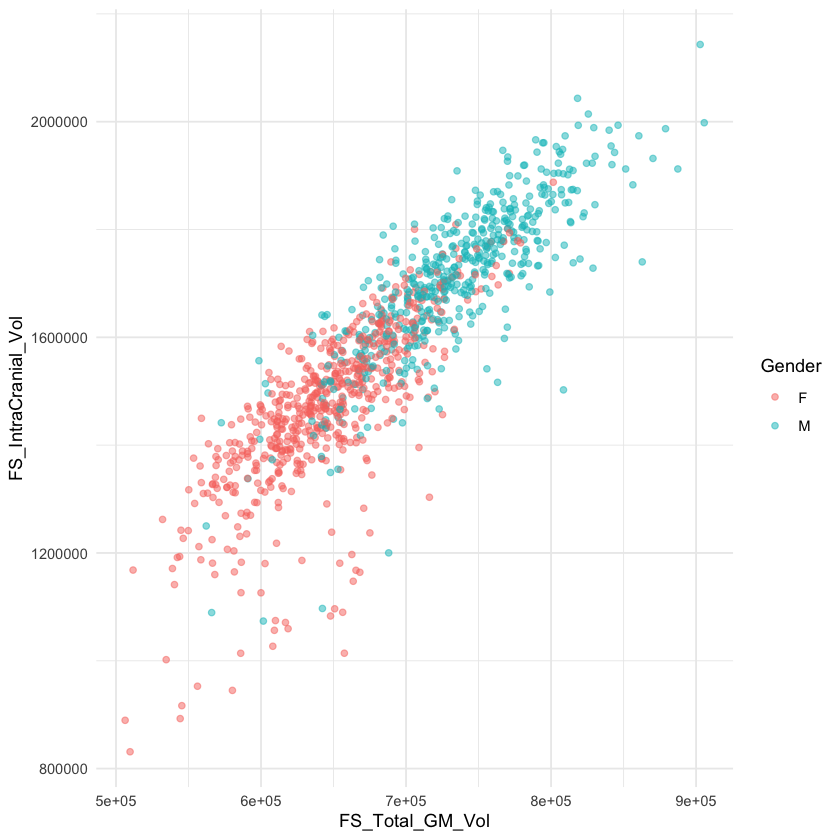

In [124]:
ggplot(d1, aes(x=FS_Total_GM_Vol, y=FS_IntraCranial_Vol, color=Gender)) + 
geom_point(alpha=0.5) + theme_minimal()


What patterns do you observe in the scatter plot?

> Overall, there is a positive relationship between total grey matter volume and intracranial volume. Women seem to have overall, lower total grey matter volume and lower intracranial volume compared to men.
> 

---
## 2. Logistic classifier (2 points)

We want to try predicting gender using the neural data you have loaded.

(a) Run a logisic regression model to predict gender from total white matter volume, total grey matter volume, and intracranial volume. 

In [125]:
d1$Gender <- as.factor(d1$Gender)
m1 <- glm(Gender ~ FS_Tot_WM_Vol + FS_Total_GM_Vol + FS_IntraCranial_Vol, data=d1, family=binomial())
print(summary(m1))


Call:
glm(formula = Gender ~ FS_Tot_WM_Vol + FS_Total_GM_Vol + FS_IntraCranial_Vol, 
    family = binomial(), data = d1)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.7695  -0.6173  -0.1863   0.5997   3.2309  

Coefficients:
                      Estimate Std. Error z value Pr(>|z|)    
(Intercept)         -2.262e+01  1.347e+00 -16.787  < 2e-16 ***
FS_Tot_WM_Vol        2.140e-06  3.059e-06   0.699    0.484    
FS_Total_GM_Vol      1.959e-05  3.145e-06   6.229 4.70e-10 ***
FS_IntraCranial_Vol  5.020e-06  1.177e-06   4.263 2.01e-05 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 1534.13  on 1112  degrees of freedom
Residual deviance:  919.85  on 1109  degrees of freedom
AIC: 927.85

Number of Fisher Scoring iterations: 5



Which factors are signficantly associated with gender?

> Total grey matter volume and intracranial volume are the factors significantly associated with gender
> 

(b) Estimate the prediction accuracy of your model (Note: this is the training set accuracy). Set your prediction threshold to 0.5.

In [126]:
glm_ld_df <- data.frame(predict(m1, type = "response"))
colnames(glm_ld_df) = c('predicted_correct')

num_obs = nrow(glm_ld_df)
glm_ld_df$index = seq(1, num_obs)

threshold = 0.5

glm_ld_df$predicted_binary=rep("F",num_obs) #list of female
glm_ld_df$predicted_binary[glm_ld_df$predicted_correct>threshold]="M" #find the rows that have prob > threshold and cast as male

confusion_df <- data.frame(glm_ld_df$predicted_binary, d1$Gender)
colnames(confusion_df) = c('predicted', 'actual')

table(confusion_df)

print(paste("Accuracy:",mean(confusion_df$predicted == confusion_df$actual)))



         actual
predicted   F   M
        F 516 110
        M  90 397

[1] "Accuracy: 0.820305480682839"


What is the prediction accuracy for gender from the full model?

>The prediction accuracy from the full model is 82%
> 

---
## 3. Bootstrapped accuracy (3 points)

Use bootstrapping to estimate the confidence intervals of the _prediction accuracy_ of your model. Plot the histogram of the bootstrapped prediction accuracies and estimate the confidence intervals off of the standard deviation from the bootstrap.


[1] 0.8203055

ORDINARY NONPARAMETRIC BOOTSTRAP


Call:
boot(data = d1, statistic = boot.fn, R = 1000)


Bootstrap Statistics :
     original    bias    std. error
t1* 0.8203055 -0.315451  0.01449674


[1] 0.7898935

[1] 0.8507175

[1] 0.01449674

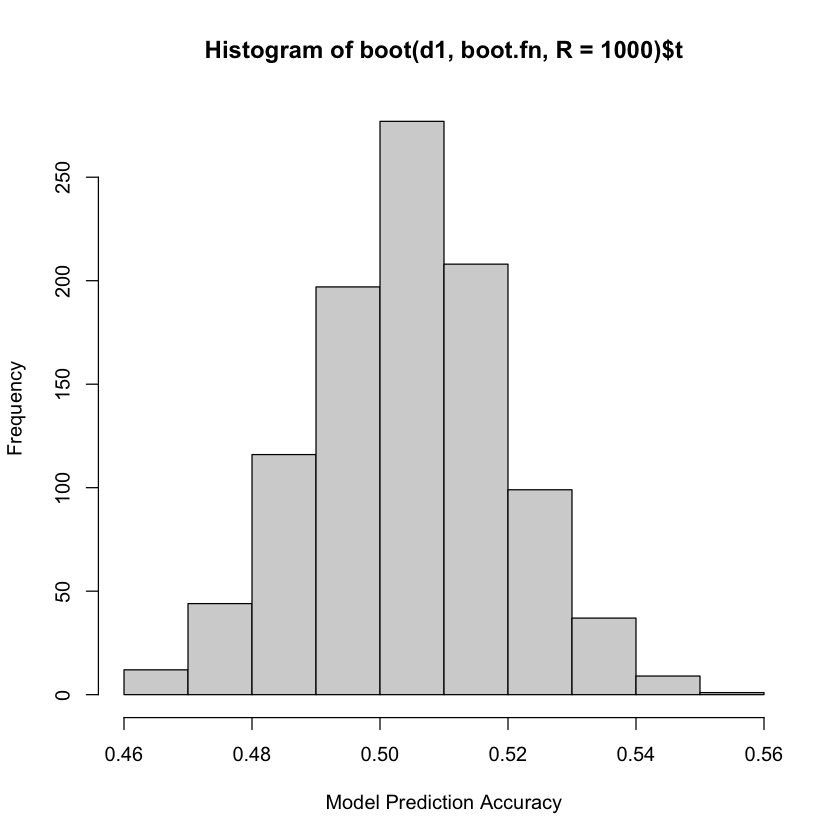

In [139]:
library(boot)

boot.fn <- function(data,index){
    m1 <- glm(Gender ~ FS_Tot_WM_Vol + FS_Total_GM_Vol + FS_IntraCranial_Vol, data=data, subset= index, family=binomial())
    glm_ld_df <- data.frame(predict(m1, type = "response"))
    colnames(glm_ld_df) = c('predicted_correct')
    num_obs = nrow(glm_ld_df)
    glm_ld_df$index = seq(1, num_obs)
    threshold = 0.5
    glm_ld_df$predicted_binary=rep("F",num_obs) 
    glm_ld_df$predicted_binary[glm_ld_df$predicted_correct>threshold]="M" 
    confusion_df <- data.frame(glm_ld_df$predicted_binary, d1$Gender)
    colnames(confusion_df) = c('predicted', 'actual')
    table(confusion_df)
    
    return(mean(confusion_df$predicted == confusion_df$actual))
}


print(boot.fn(d1, 1:1113)) #same as what i got from Q2 so it works
boot_obj = boot(d1 ,boot.fn ,R=1000) #R=repetitions 
print(boot_obj) 

hist(boot(d1 ,boot.fn ,R=1000)$t, xlab = "Model Prediction Accuracy")




In [144]:
boot_obj$t %>% sd()
boot_obj$t %>% mean() 

CI_value = 1.96*boot_obj$t %>% sd()
#calculating CI values
(boot_obj$t %>% mean()) - CI_value
(boot_obj$t %>% mean()) + CI_value

[1] 0.01449674

[1] 0.5048544

[1] 0.4764408

[1] 0.533268

How robust is the prediction accuracy of the full model?

> The 95% CI for the predication accuracy is \[.47,.53\]. This CI does include our previous accuracy value of 82%. Given the histogram distribution and high bias estimate, overall the bootstrapping does not suggest a robust prediction accuracy.

---
## 4. Permutation test for grey matter effects (3 points)

Now run a permutation test, with 1000 iterations, to evaluate how much grey matter volume contributes to the prediction accuracy. Compare the prediction accuracy of the full (unpermuted model) with the distribution of accuracies you get with a randomized grey matter volume term using a histogram (Hint: use the `abline` function to show the original accuracy on the histogram).

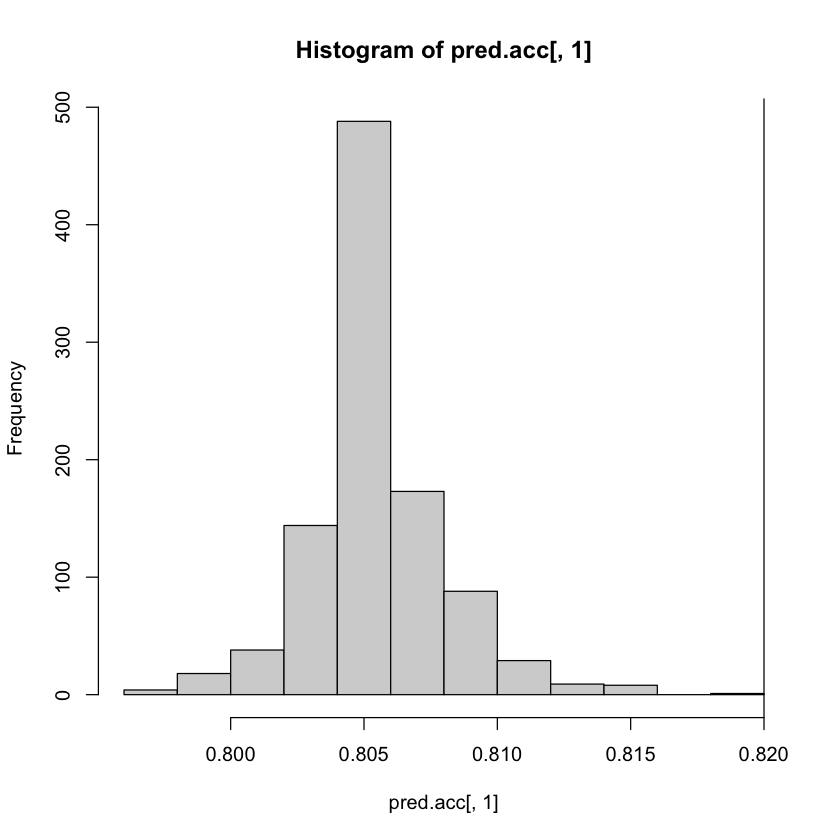

In [157]:
predacc.fn <- function(data, model){ 
    glm_ld_df <- data.frame(predict(m1, type = "response"))
    colnames(glm_ld_df) = c('predicted_correct')
    num_obs = nrow(glm_ld_df)
    glm_ld_df$index = seq(1, num_obs)
    threshold = 0.5
    glm_ld_df$predicted_binary=rep("F",num_obs) 
    glm_ld_df$predicted_binary[glm_ld_df$predicted_correct>threshold]="M" 
    confusion_df <- data.frame(glm_ld_df$predicted_binary, d1$Gender)
    colnames(confusion_df) = c('predicted', 'actual')
    table(confusion_df)
    
    return(mean(confusion_df$predicted == confusion_df$actual))
           }


permd1=d1
R=1000

perm.coefs=matrix(NA,nrow=R, ncol=4) 
pred.acc=matrix(NA, nrow=R, ncol=1) 
predacc.real=matrix(0.820305480682839, nrow=R, ncol=1) 

for (i in 1:R){
  permd1$FS_Total_GM_Vol=d1$FS_Total_GM_Vol[sample(1113)] 
  perm.coefs[i,]=coef(glm(Gender ~ FS_Tot_WM_Vol + FS_Total_GM_Vol + FS_IntraCranial_Vol, data = permd1, family = "binomial"))
   m1=glm(Gender ~ FS_Tot_WM_Vol + FS_Total_GM_Vol + FS_IntraCranial_Vol, data = permd1, family = "binomial")
   pred.acc[i,]=predacc.fn(permd1, m1)
}

hist(pred.acc[,1])
abline(v=0.820)


In [161]:
perm.p = sum(pred.acc[,1]<0.820305480682839)/R 
perm.p

[1] 1

How much does the grey matter volume influence the prediction accuracy of the model?

> Grey matter volume significantly influences the prediction accuracy of the model. Scrambling the total grey matter volume variable reduces the prediction accuracy. We can reject the null hypothesis that total grey matter volume does not influence prediction accucary of our model.<br>
> *Estimating for how much grey matter volumen influences the prediction accuracy: Since the bootstrapped CI ranged from ~47-53% and the bias was ~30%, it appears that gray matter volume positively influces the prediction accuracy of the model by ~30%.*

---
## 5. Reflection (1 point)

Differentiate the bootstrap from a permutation test. Describe each and when is it appropriate to each.

> With Bootstrapping, the goal is sampling the distribution of effects. We get this distribution of effects by sampling with replacment, generation a new distrubtion to draw from. Use boostrapping when we want to find the expected range of values can we expect for a statistic, given variability in the data.<br>
> With Permutation, the goal is to break the relationship between X and Y but maintains distribution of X. WIth permuation, we sample without replacement, thus we are not generating a new distrubtion but simply redistributing the data. We can use permutation test for targeted null hypothesis testing. We use it when we want to answer what kind of pattern do we expect to see if there were no statistical relationship between x and y* 


**DUE:** 5pm EST, April 1, 2022

**IMPORTANT** Did you collaborate with anyone on this assignment? If so, list their names here. 
> *Danielle F., Avital P., Delainey W.*